Теорема Пика:
$$S=I+\frac{B}{2}-1$$
Где S - площадь многоугольника, I - количество точек с целочисленными координатами, лежащих строго внутри многоугольника, B - количество точек с целочисленными координатами, лежащих на сторонах многоугольника.

По условию, внутри лежит 0 точек, а на границе 3 (вершины). Получаем, что площадь искомого треугольника равна $\frac{1}{2}$

Далее, известно, что если у нас есть отрезок $AB$, где $\ A(x_1, y_1)$, а $\ B(x_2, y_2)$, причем $x_1, x_2, y_1, y_2 - $ целые числа. То для того, чтобы на отрезке $AB$ не лежало других целочисленных точек, необходимо и достаточно, чтобы $gcd\left(|x_2-x_1|, |y_2-y_1|\right) = 1$. То есть наибольший общий делитель длин проекций отрезка на каждую из осей был равен единице (т.е. числа взаимно простые)

Таким образом, можно сделать вывод, что если зафиксировать одну сторону треугольника, то его высота определяется однозначно: $S = \frac{1}{2}ah, \ S = \frac{1}{2}, \ h = \frac{S}{0.5a}, \ h = \frac{0.5}{0.5a} = \frac{1}{a}$, где a - длина зафиксированной стороны. Это позволяет сформулировать утверждение: если мы зафиксировали одну сторону треугольника (без целочисленных точек на этом отрезке, кроме концов), а затем нашли целочисленную точку, которая находится на минимальном расстоянии от зафиксированного отрезка (но не лежит на той же прямой), то мы можем утверждать, что эта точка может являться третьей вершиной треугольника, то есть все условия на треугольник будут выполнены. И причем в качестве третьей вершины нас интересуют только такие точки, которые минимально удалены от зафиксированной стороны треугольника. Это легко следует из того, что высота треугольника (высота теперь это как раз расстояние от третьей точки до отрезка) является зафиксированным числом, то есть, если нам подходит эта точка в качестве третьей, мы не можем взять какую-то другую, которая будет дальше от фиксированного отрезка. А то, что точка, минимально удаленная от отрезка нам подходит - понятно, так как в таком случае внутри треугольника действительно не будет целочисленных узлов, ведь если бы они были, это означало бы, что они находятся ближе к отрезку, чем третья вершина, что противоречит выбору третьей вершины.

Для начала, напишем перебор и посмотрим (просто для наглядности) как выглядят ответы для разных радиусов окружности

In [30]:
import multiprocessing
import psutil
from math import gcd, sqrt
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor

In [31]:
# проверяет, лежит ли точка (x, y) внутри или на границе круга
# радиуса r с центром в начале координат
def in_circle(x, y, r):
    return x**2 + y**2 <= r**2

# возвращает удвоенную площадь треугольника с вершинами в точках
# с координатами (x1, y1), (x2, y2), (x3, y3)
def triangle_area2(x1, y1, x2, y2, x3, y3):
    return abs((x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2)))

# расстояние между двумя точками
def dst(x1,y1,x2,y2):  
     return sqrt((x2 - x1)**2 + (y2 - y1)**2)  

# периметр треугольника
def triangle_perimeter(x1, y1, x2, y2, x3, y3):
    return dst(x1,y1,x2,y2) + dst(x1,y1,x3,y3) + dst(x2,y2,x3,y3)
    
# перебор
# input_data - массив из трех чисел:
# начало и конец границы перебора, а также радиус окружности
def solve(input_data):
    start, finish, R = input_data
    ans = []   
    for x1 in (range(start, finish)):
        for y1 in range(-R, R+1):
            if not in_circle(x1, y1, R):
                continue
            for x2 in range(x1, R + 1):
                for y2 in range(-R, R+1):
                    if not in_circle(x2, y2, R):
                        continue
                    if gcd(abs(x1-x2), abs(y1-y2)) != 1:
                        continue
                    for x3 in range(x2, R + 1):
                        for y3 in range(-R, R+1):
                            if not in_circle(x3, y3, R):
                                continue
                            if gcd(abs(x1-x3), abs(y1-y3)) != 1:
                                continue 
                            if gcd(abs(x2-x3), abs(y2-y3)) != 1:
                                continue 
                            if triangle_area2(x1, y1, x2, y2, x3, y3) != 1:
                                continue
                            ans.append((
                                (dst(x1,y1,x2,y2) + dst(x1,y1,x3,y3) + dst(x2,y2,x3,y3)),
                                (x1, y1, x2, y2, x3, y3)
                            ))
                            ans = sorted(ans, reverse=True)[:100]
    return ans

# распараллелим перебор
def parallel_solve(r, num=32):
    p = Pool(num)
    result = p.map(solve, get_chunks(start=-r, finish=r+1, r=r, num=num))
    result = [x for array in result for x in array]
    result = sorted(result, reverse=True)
    return result

In [32]:
# ф-ция котрая рисует все ответы для заданного радиуса
# то есть треугольники с максимальным периметром
def show_ans(r, num=32):
    
    ans = parallel_solve(r, num)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.grid(linestyle='--')
    ax.set_aspect(1)
    
    circle1 = plt.Circle((0, 0), r, color='black', fill=False)
    ax.add_artist(circle1)
    
    cnt = 1
    # отобразим на рисунке все треугольники с максимальным периметром
    while ans[cnt][0] == ans[cnt - 1][0]:
        cnt += 1 
    
    for i in range(cnt):
        x1, y1, x2, y2, x3, y3 = ans[i][1]
        plt.plot([x1,x2],[y1,y2], marker='o')
        plt.plot([x1,x3],[y1,y3], marker='o')
        plt.plot([x2,x3],[y2,y3], marker='o')
        
    plt.xticks(np.arange(-r-1,r+1))
    plt.yticks(np.arange(-r-1, r+1))

    plt.xlabel('X', fontsize=18)
    plt.ylabel('Y', fontsize=18)
    plt.title('Радиус: %s\nМаксимальный периметр: %s' % (r, ans[0][0]), fontsize=18)
    
    plt.xlim(-r-1,r+1)
    plt.ylim(-r-1,r+1)
    plt.show()

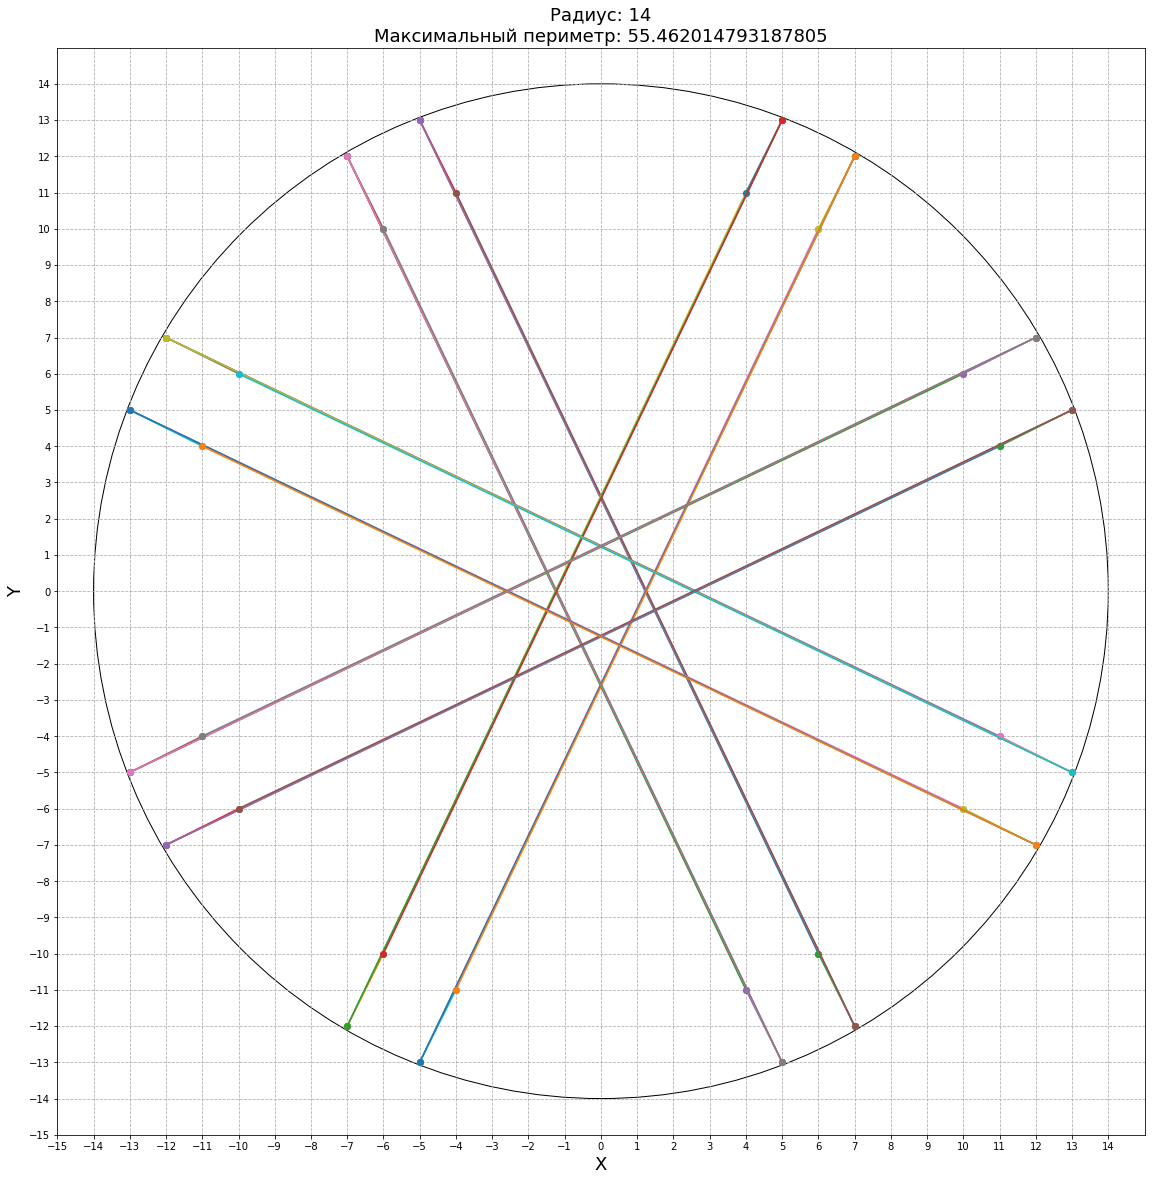

In [37]:
show_ans(14, num=28)

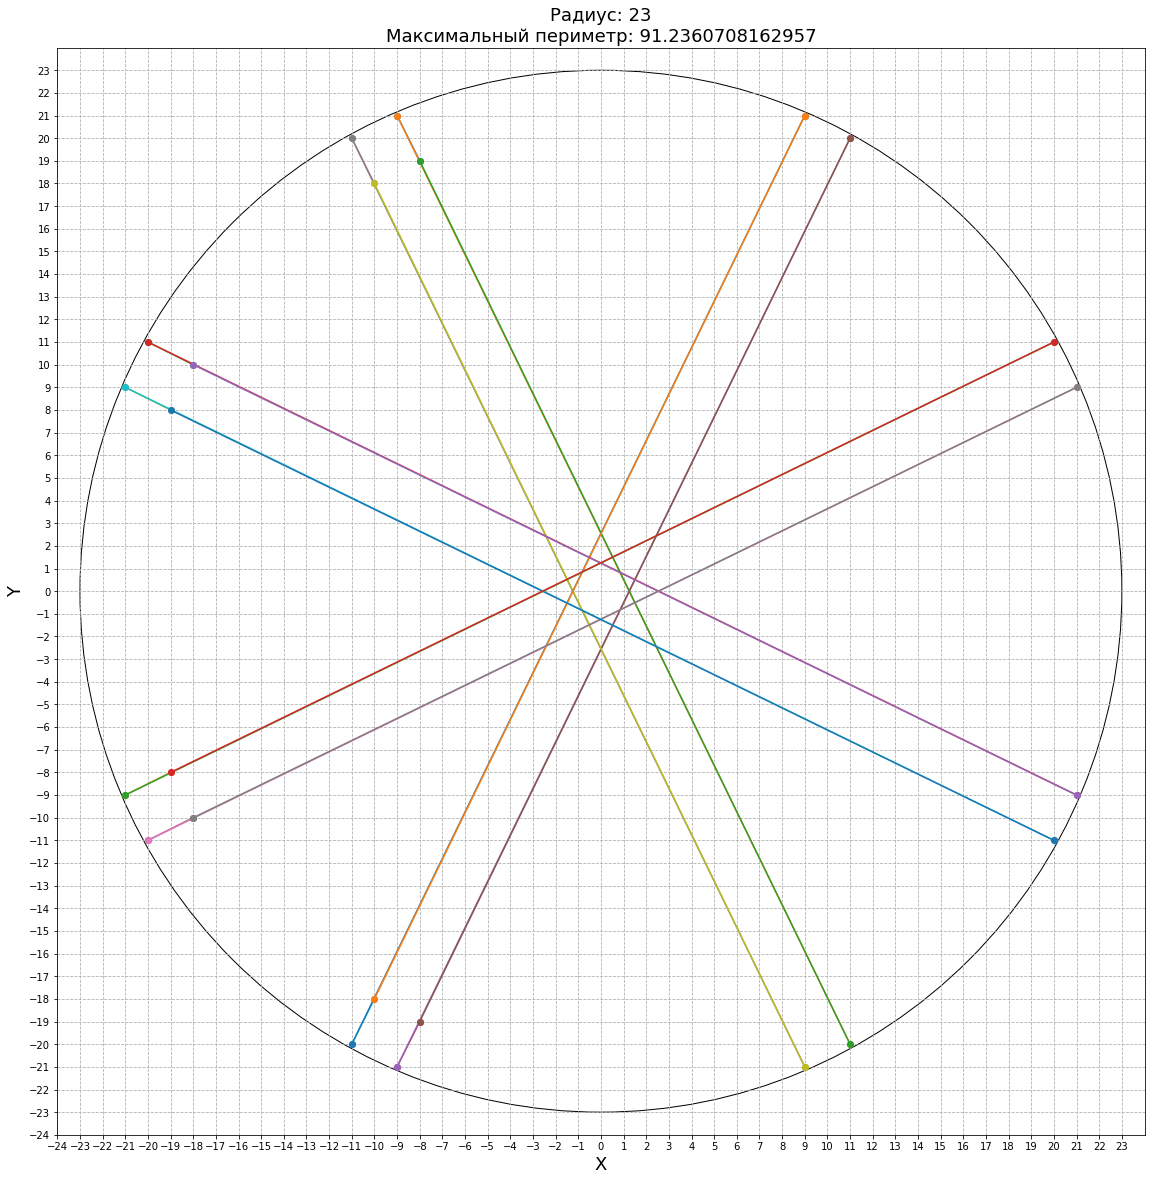

In [39]:
show_ans(23, num=23)

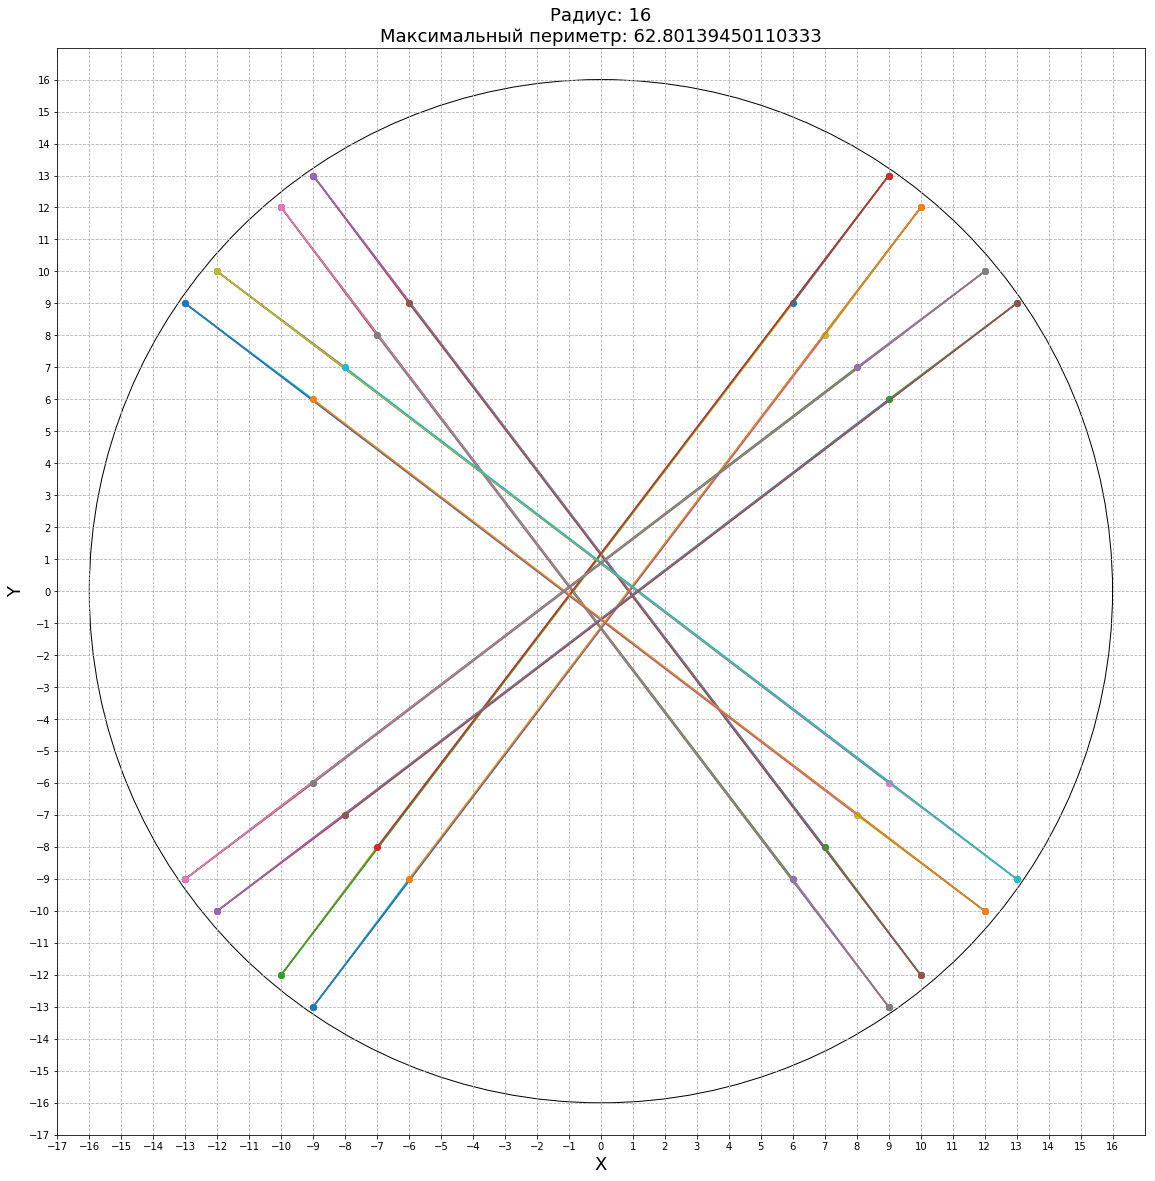

In [38]:
show_ans(16, num=32)

При внимательном рассмотрении примеров, можно выдвинуть гипотезу, что треугольник с наибольшим периметром имеет одну из своих вершин в точке, максимально приближенной к окружности, а вторая же точка -- это точка, которая максимально удалена от первой точки (при том, что, разумеется, выполяется условие, что на отрезке нет целочисленных точек кроме концов). При этом, понятно, что достаточно искать первую точку в 1 четверти (в силу симметричности окружности) Это наводит на следующую мысль: давайте рассмотрим множество точек (x, y), такое, что x пробегает все значения от 1 до R, а y определяется так, чтобы при фиксированном x, точка (x, y) была максимально близко к окружности. Давайте осортируем все эти точки (их R штук) по возрастанию расстояния до окружности и посмотрим на первые несколько точек. Для каждой точки найдем самую удаленную от нее (в 3 четверти). Таким образом зафиксировав две точки, найдем третью, как описывалось ранее (как самую близкую точку к заданному отрезку). Итак, мы получили треугольник, осталось выбрать из всех рассмотренных треугольников тот, у которого периметр наибольший

In [60]:
# расстояние от точки до окружности
def dist_to_circle(x, y, r):
    return abs(sqrt(x**2+y**2)-r)

# для заданного икса ищет наиближайшую к окружности 
# точку с целочисленными координатами 
def get_upper_point_y(x, radius):
    l, r = 0, radius
    while r - l > 1:
        mid = (l + r) // 2
        if in_circle(r=radius, x=x, y=mid):
            l = mid
        else:
            r = mid
    if in_circle(r=radius, x=x, y=r):
        return r
    else:
        return l

# ищем самые близкие точки к окружности
def fast_find_closest(input_data):
    # left, right - границы отрезка, по которому перебираем x
    left, right, r = input_data
    ans = []
    for x in (range(left, right)):
        y = get_upper_point_y(x, r)
        assert in_circle(r=r, x=x, y=y)
        ans.append((
            dist_to_circle(x, y, r),
            (x, y)
        ))
        ans = sorted(ans)[:100]
        
    return sorted(ans)

# аналогично, но параллельно
def parallel_find_closest(r):
    num = 32
    p = Pool(num)
    result = p.map(fast_find_closest, get_chunks(start=1, finish=r, r=r, num=num))
    result = sorted([x for array in result for x in array])
    p.close()
    return result

# ищем в 3 четверти самую удаленную точку от данной 
# с целыми координатами внутри круга
# p = (x1, y1) - данная точка в 1 четверти
def fast_find_farthest(input_data):
    start, finish, r, x1, y1 = input_data
    ans = []
    assert x1 >= 0 and x1 <= r and y1 >= 0 and y1 <= r and in_circle(x=x1, y=y1, r=r)
    for x2 in range(start, finish):
        y2 = -get_upper_point_y(x2, r)
        if gcd(abs(x2-x1), abs(y2-y1)) != 1:
            continue
        ans.append((
            dst(x1=x1, x2=x2, y1=y1, y2=y2),
            (x2, y2)
        ))
        ans = sorted(ans, reverse=True)[:100]
    return ans

# делаем то же, но параллельно
def parallel_find_farthest(r, x1, y1):
    num = 32
    p = Pool(num)
    result = p.map(fast_find_farthest, get_chunks(x1, y1, 
                                                  start=-r, finish=1, r=r, num=num))
    result = sorted([x for array in result for x in array], reverse=True)
    p.close()
    return result

# расстояние от отрезка ab до точки p
def dist (a, b, p):
    x1, y1 = float(a[0]), float(a[1])
    x2, y2 = float(b[0]), float(b[1])
    x0, y0 = float(p[0]), float(p[1])
    return abs((y2-y1) * x0 - (x2 - x1) * y0 + x2*y1 - y2*x1) \
        / sqrt((y2 - y1)**2 + (x2 - x1)**2)

# (x1, y1) -- точка в 3 четверти
# ищем третью точку по описанному выше алгоритму
# то есть выбираем ближайшую точку к фиксированному отрезку
def fast_find_third_point(input_data):
    start, finish, r, x1, y1, x2, y2 = input_data
    ans = []
    x3, y3 = x1, y1 + 1
    if in_circle(r=r, x=x3, y=y3):
        ans.append((
            dist((x1, y1), (x2, y2), (x3, y3)),
            (x3, y3)
        ))
    x3, y3 = x1, y1 - 1
    if in_circle(r=r, x=x3, y=y3):
        ans.append((
            dist((x1, y1), (x2, y2), (x3, y3)),
            (x3, y3)
        ))
    for x3 in range(start, finish):
        # просто подставляем в уравнение прямой и округляем 
        # в разные стороны
        A = y1-y2
        B = x2-x1
        C = x1*y2 - x2*y1
        y3 = (-C - A*x3) / B
        y31 = ceil(y3)
        y32 = floor(y3)
        if in_circle(r=r, x=x3, y=y31):
            ans.append((
                dist((x1, y1), (x2, y2), (x3, y31)),
                (x3, y31)
            ))
        if in_circle(r=r, x=x3, y=y32):
            ans.append((
                dist((x1, y1), (x2, y2), (x3, y32)),
                (x3, y32)
            ))
        ans = sorted(ans)[:100]
    return sorted(ans)

#  параллельно делаем то же самое
def parallel_find_third_point(x1, y1, x2, y2, r):
    num = 32
    p = Pool(num)
    result = p.map(fast_find_third_point, get_chunks(x1, y1, x2, y2, start=x1+1, 
                                                     finish=x2, r=r, num=num))
    result = sorted([x for array in result for x in array])
    p.close()
    return result


In [36]:
# получаем разбиение отрезка на несколько равных частей, чтобы
# передавать входнные данные частями параллельно в несколько потоков
def get_chunks(*args, start, finish, r, num):
    ans = []
    cnt = (finish - start - 1) // num 
    if cnt == -1:
        return [[start, finish, r, *args]]
    x = start
    for i in range(num - 1):
        assert x + cnt <= finish
        ans.append([x, x + cnt, r, *args])
        x += cnt
    ans.append([x, finish, r, *args])
    return ans


Запишем в массив самые близкие к окружности точки в 1 четверти

In [11]:
r = 10**7
closest10_7 = parallel_find_closest(r=r)

In [50]:
# можно заметить, что для нахождения наиболее удаленной точки от данной
# достаточно смотреть точки рядом с симметричной данной относительно нуля точкой 
def parallel_find_farthest_2(r, x1, y1):
    num = 32
    p = Pool(num)
    result = p.map(fast_find_farthest,
                   get_chunks(x1, y1, start=max(-r, -x1-1000), 
                              finish=min(1, -x1+1000), r=r, num=num))
    result = sorted([x for array in result for x in array], reverse=True)
    p.close()
    return result


Сам перебор:

In [26]:
best_points = None
best_perimeter = 0
for i in tqdm(range(200)):
    # взяли близкую к окружности 
    # точку в 1 четверти 
    x1, y1 = closest10_7[i][1]
    # получили самые удаленные точки от первой  
    farthest_point = parallel_find_farthest_2(r=r, x1=x1, y1=y1)
    x2, y2 = farthest_point[0][1]
    # получили точки, которые ближе всего находятся к данному отрезку
    third_points = parallel_find_third_point(x2=x1, y2=y1, x1=x2, y1=y2, r=r)[:10]
    cnt = 1
    # посчитали сколько среди них таких, в которых достигается минимальное расстояние
    # все они нам подходят
    while cnt < len(third_points) and third_points[cnt][0] == third_points[cnt - 1][0]:
        cnt += 1
    # для каждой из них посчитали периметр полученного треугольника
    # выбрали максимальный
    for j in range(cnt):
        third_point = third_points[j][1]
        x3, y3 = third_point
        cur_perimeter = triangle_perimeter(x1=x1, y1=y1, x2=x2, y2=y2, x3=x3, y3=y3)
        if cur_perimeter > best_perimeter:
            best_perimeter = cur_perimeter
            best_points = ((x1, y1), (x2, y2), (x3, y3))
            
print(best_perimeter)
print(best_points)


39999999.9998641
((5010340, 8654276), (-5010359, -8654265), (-3499776, -6045067))


Таким образом, мы получили какой-то ответ, давайте проверим что он удовлетворяет условиям:

In [42]:
x1, y1 = (5010340, 8654276)
x2, y2 = (-5010359, -8654265)
x3, y3 = (-3499776, -6045067)

In [56]:
# проверяем что ни на одном из трех отрезков нет целых точек кроме концов
print('gcd = ', gcd(abs(x1 - x2), abs(y1 - y2)))
print('gcd = ', gcd(abs(x1 - x3), abs(y1 - y3)))
print('gcd = ', gcd(abs(x2 - x3), abs(y2 - y3)))
# считаем площадь
print('2*S = ',triangle_area2(x1=x1, x2=x2, x3=x3, y1=y1, y2=y2, y3=y3))
# проверяем, что вершины действительно внутри круга
print('вершина внутри круга:', in_circle(r=10**7, x=x1, y=y1))
print('вершина внутри круга:', in_circle(r=10**7, x=x2, y=y2))
print('вершина внутри круга:', in_circle(r=10**7, x=x3, y=y3))
# считаем периметр
print("P = %.20f" % triangle_perimeter(x1=x1, x2=x2, x3=x3, y1=y1, y2=y2, y3=y3))

gcd =  1
gcd =  1
gcd =  1
2*S =  1
вершина внутри круга: True
вершина внутри круга: True
вершина внутри круга: True
P = 39999999.99986410140991210938


Таким образом, видно, что на сторонах нет целых точек, а площадь $S = \frac{1}{2}$. Значит, по теореме Пика, внутри тоже нет целых точек

Таким образом, мы получили треугольник, у которого периметр примерно равен:

39999999.99986410140991210938

Вершины:

(5010340, 8654276),

(-5010359, -8654265),

(-3499776, -6045067)

Юсупов Никита, ФИВТ МФТИ 3 курс

7999-260-74-95

nikitayusupov@gmail.com